In [101]:
## Standard libraries
import os
import gc
import numpy as np
import pandas as pd
import random
import math
import json
from functools import partial, reduce
import argparse
import copy
import time
from datetime import datetime

from typing import TextIO, Callable, Collection, Dict, Iterator, List, Tuple, Type, TypeVar
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score
T = TypeVar("T", bound="EyetrackingClassifier")
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# PyTorch Lightning
import pytorch_lightning as pl

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/transformer"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


## Setup

In [2]:
# Global variables
NUM_FEATURES = 14
NUM_FIX = 30 

In [3]:
# Helper functions

def mask_with_tokens(t, token_ids):
    init_no_mask = torch.full_like(t, False, dtype=torch.bool)
    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)
    return mask

def mse_loss(target, input, mask):
    out = (input[mask]-target[mask])**2
    return out.mean()

def mask_with_tokens_3D(t, token_ids):
    init_no_mask = torch.full_like(t, False, dtype=torch.bool)
    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)
    reduced = torch.any(mask, dim=-1, keepdim=True)
    expanded = reduced.expand_as(mask)
    return expanded

def get_mask_subset_with_prob_3D(mask, prob):
    batch, num_fix, num_features, device = *mask.shape, mask.device
    max_masked = math.ceil(prob * num_fix)

    num_tokens = mask.sum(dim=-2, keepdim=True)
    mask_excess = (mask.cumsum(dim=-2)[:,:,0] > (num_tokens[:,:,0] * prob).ceil())
    mask_excess = mask_excess[:, :max_masked]

    rand = torch.rand((batch, num_fix, num_features), device=device).masked_fill(~mask, -1e9)
    _, sampled_indices = rand.topk(max_masked, dim=-2)
    sampled_indices = (sampled_indices[:,:,0] + 1).masked_fill_(mask_excess, 0)

    new_mask = torch.zeros((batch, num_fix + 1), device=device)
    new_mask.scatter_(-1, sampled_indices, 1)
    new_mask = new_mask[:, 1:].bool()
    
    return new_mask.unsqueeze_(2).expand(-1,-1, num_features)
    

def prob_mask_like_3D(t, prob):
    temp = torch.zeros_like(t[:,:,0]).float().uniform_(0, 1) < prob
    return temp.unsqueeze_(2).expand(-1,-1, NUM_FEATURES)
    
    
def pad_group_with_zeros(group, target_rows):
    # Calculate the number of rows to add
    num_missing_rows = target_rows - len(group)
    if num_missing_rows > 0:
        # Create a DataFrame with the required number of padding rows
        # input padding
        zero_rows = pd.DataFrame(0.3333, index=range(num_missing_rows), columns=group.columns)
        # Label padding
        # zero_rows.iloc[:, 0] = 31
        # Concatenate the group with the zero rows
        group = pd.concat([group, zero_rows], ignore_index=True)
    return group

# class ToTensor(object):
#     """Convert Series in sample to Tensors."""

#     def __call__(self, sample):
#         trial, label = sample['trial'], sample['label']
#         trial = torch.from_numpy(trial).float()
#         label = torch.from_numpy(label).float()
#         return trial, label

In [4]:
class CustomPositionalEncoding(nn.Module):
    """Learnable positional encoding for both features and fixations
    Assumes input `x` is of shape [batch_size, fixations, embed_dim]"""
    def __init__(self, fixations = 30, features = None):
        super(CustomPositionalEncoding, self).__init__()
        
        # Initialize a learnable positional encoding matrix
        self.encoding = nn.Parameter(torch.zeros(fixations, features)).to(device)
        nn.init.xavier_uniform_(self.encoding)  # Xavier initialization for better training stability
        
    def forward(self, x, mask = None):
        if mask is not None:
            # Apply the mask to ignore padded positions
            pos_encoding = self.encoding  * mask
        else:
            pos_encoding = self.encoding
        return x + pos_encoding

In [5]:
class AnnasPositionalEncoding(nn.Module):
    """Learnable positional encoding for both features and fixations
    Assumes input `x` is of shape [batch_size, fixations, embed_dim]"""
    def __init__(self, fixations = int, features = int):
        super(AnnasPositionalEncoding, self).__init__()
        
        # Initialize a learnable positional encoding matrix for fixations
        self.fix_encoding = nn.Parameter(torch.zeros(fixations, 1)).to(device)
        nn.init.xavier_uniform_(self.fix_encoding)  # Xavier initialization for better training stability
        self.fix_encoding = self.fix_encoding.expand(-1, features)
        
        # Initialize a learnable positional encoding matrix for features
        self.feat_encoding = nn.Parameter(torch.zeros(1, features)).to(device)
        nn.init.xavier_uniform_(self.feat_encoding)  # Xavier initialization for better training stability
        self.feat_encoding = self.feat_encoding.expand(fixations, -1)
        
        self.encoding = self.fix_encoding + self.feat_encoding
        
    def forward(self, x, mask = None):
        if mask is not None:
            # Apply the mask to ignore padded positions
            pos_encoding = self.encoding  * mask
        else:
            pos_encoding = self.encoding
        return x + pos_encoding

In [6]:
class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=278, l2norm_embed = False):
        super().__init__()
        self.scale = dim ** -0.5 if not l2norm_embed else 1.
        self.max_seq_len = max_seq_len
        self.l2norm_embed = l2norm_embed
        self.emb = nn.Embedding(max_seq_len, dim)

    def forward(self, x, pos = None, seq_start_pos = None, mask = None):
        seq_len, device = x.shape[1], x.device
        assert seq_len <= self.max_seq_len, f'you are passing in a sequence length of {seq_len} but your absolute positional embedding has a max sequence length of {self.max_seq_len}'

        #if not exists(pos):
        pos = torch.arange(seq_len, device = device)

        #if exists(seq_start_pos):
        #    pos = (pos - seq_start_pos[..., None]).clamp(min = 0)

        pos_emb = self.emb(pos)
        pos_emb = pos_emb * self.scale
        
        if mask is not None:
            # Apply the mask to ignore padded positions
            pos_emb = pos_emb * mask
            
        return l2norm(pos_emb) if self.l2norm_embed else pos_emb


In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=278):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model%2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:,0:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).to(device)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x, mask = None):
        pos_enc = self.pe[:, :x.size(1)]
        if not(mask == None):
            mask = mask.to(device)
            pos_enc = pos_enc*mask
        return x + pos_enc

## Data preparation

In [8]:
#LinguisticFeature = Callable[[Tuple[str]], Tuple[torch.Tensor]]

# def apply_standardization(x, m, sd):
#     nonzero_sd = sd.clone()
#     nonzero_sd[sd == 0] = 1
#     x = torch.from_numpy(x).float()
#     res = (x - m.unsqueeze(0)) / nonzero_sd.unsqueeze(0)
#     return res

def apply_standardization(x, m, sd):
    nonzero_sd = sd.clone()
    nonzero_sd[sd == 0] = 1
    x = torch.from_numpy(x).float()
    x_zeros = x[x.sum(dim=(1)) == 0]
    x_zeros[x_zeros==0] = -5
    x_non_zeros = x[x.sum(dim=(1)) != 0]
    x_non_zeros = (x_non_zeros - m.unsqueeze(0)) / nonzero_sd.unsqueeze(0)
    res = torch.cat((x_non_zeros, x_zeros), axis =0)
    return res


def aggregate_per_subject(subjs, y_preds, y_preds_class, y_trues):
    y_preds = np.array(y_preds)
    y_preds_class = np.array(y_preds_class)
    y_trues = np.array(y_trues)
    subjs = np.array(subjs).flatten()
    y_preds_subj = []
    y_preds_class_subj = []
    y_trues_subj = []
    subjs_subj = np.unique(subjs)
    for subj in subjs_subj:
        subj = subj.item()
        y_pred_class_subj = y_preds_class[subjs == subj]
        y_pred_subj = y_preds[subjs == subj]
        y_true_subj = y_trues[subjs == subj]
        assert len(np.unique(y_true_subj)) == 1, f"No unique label: subj={subj}"
        y_trues_subj.append(np.unique(y_true_subj).item())
        y_preds_subj.append(np.mean(y_pred_subj).item())
        if sum(y_pred_class_subj) >= (len(y_pred_class_subj) / 2):
            y_preds_class_subj.append(1)
        else:
            y_preds_class_subj.append(0)
    return subjs_subj, y_preds_subj, y_preds_class_subj, y_trues_subj

def getmeansd(dataset, batch: bool = False):  # removing rows of 0s
    if batch:
        # Anna added preprocessing from ndarray to torch
        tensors = [X for X, _, _, _ in dataset]  #torch.from_numpy(X).float()
        tensors = torch.cat(tensors, axis=0)
        # remove padded tensors
        tensors = tensors[tensors.sum(dim=(1,2)) != 0]   #tensors[tensors.sum(dim=(1, 2)) != 0]
        # remove rows of 0s from the computation
        sentences, timesteps, features = tensors.size()
        subset = tensors.sum(dim=(2)) != 0
        subset = subset.view(sentences, timesteps, 1)
        subset = subset.expand(sentences, timesteps, features)
        result = tensors[subset].view(-1, features) 
        
        means = torch.mean(result, dim=(0))
        sd = torch.std(result, dim=(0))
        return means, sd
    else:
        tensors = [torch.from_numpy(X).float() for X, _, _, _ in dataset] # Anna added , was [X for X, _, _ in dataset]
        tensors = torch.cat(tensors, axis=0)
        # remove padded tensors
        tensors = tensors[tensors.sum(dim=1) != 0]
        means = torch.mean(tensors, 0)
        sd = torch.std(tensors, 0)
        return means, sd
    
    
# def get_params(paramdict) -> dict:
#     selected_pars = dict()
#     for k in paramdict:
#         selected_pars[k] = random.sample(list(paramdict[k]), 1)[0]
#     return selected_pars

In [9]:
def aggregate_speed_per_subject(subjs, y_preds, y_trues):
    y_preds = np.array(y_preds)
    #y_preds_class = np.array(y_preds_class)
    y_trues = np.array(y_trues)
    subjs = np.array(subjs).flatten()
    y_preds_subj = []
    y_trues_subj = []
    subjs_subj = np.unique(subjs)
    for subj in subjs_subj:
        subj = subj.item()
        y_pred_subj = y_preds[subjs == subj]
        y_true_subj = y_trues[subjs == subj]
        assert len(np.unique(y_true_subj)) == 1, f"No unique label: subj={subj}"
        y_trues_subj.append(np.unique(y_true_subj).item())
        y_preds_subj.append(np.mean(y_pred_subj).item())

    return subjs_subj, y_preds_subj, y_trues_subj

In [10]:
class EyetrackingDataPreprocessor(Dataset):
    """Dataset with the long-format sequence of fixations made during reading by dyslexic 
    and normally-developing Russian-speaking monolingual children."""

    def __init__(
        self, 
        csv_file, 
        transform=None, 
        target_transform=None,  
        num_folds: float = 10,
        ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable, optional): Optional transform to be applied
                on a label.
        """
        data = pd.read_csv(csv_file)
        
        # changing dyslexia labels to 0 and 1
        if {'group'}.issubset(data.columns):   # not the case for pretrain dataset
            data['group'] = data['group'] + 0.5
        
        # log-transforming frequency
        to_transform = ['frequency', 'predictability', 'fix_dur'] #
        for column in to_transform:
            data[column] = data[column].apply(lambda x: np.log(x) if x > 0 else 0) 
        
        # drop columns we don't use
        data = data.drop(columns = ['fix_x', 'fix_y', 'fix_index'])  
        
        # center reading sopeed in case we need to predict it
        if {'Reading_speed'}.issubset(data.columns):
            data['Reading_speed'] = (data['Reading_speed'] - data['Reading_speed'].mean())/data['Reading_speed'].std(ddof=0)
        
        if {'sex', 'Grade'}.issubset(data.columns):
            data = data.drop(columns = ['sex', 'Grade'])
            
        convert_columns = ['direction']
        
        if {'IQ', 'Sound_detection', 'Sound_change'}.issubset(data.columns):
            data = data.drop(columns = ['IQ', 'Sound_detection', 'Sound_change'])
        
        for column in convert_columns:
            prefix = column + '_dummy'
            data = pd.concat([data, pd.get_dummies(data[column], 
                                    prefix=prefix)], axis=1)
            data = data.drop(columns = column)

        data.dropna(axis = 0, how = 'any', inplace = True)

            
        # rearrange columns (I need demogrpahic information to come last)
#         cols = ['item', 'subj', 'group', 'Reading_speed', 'fix_dur', 'landing', 'word_length',
#                  'predictability', 'frequency', 'number.morphemes', 'next_fix_dist',
#                  'sac_ampl', 'sac_angle', 'sac_vel', 'rel.position', 'direction_dummy_DOWN',
#                  'direction_dummy_LEFT', 'direction_dummy_RIGHT', 'direction_dummy_UP',
#                  'sex', 'Age', 'Grade_dummy_1', 'Grade_dummy_2', 'Grade_dummy_3', 'Grade_dummy_4',
#                  'Grade_dummy_5', 'Grade_dummy_6']
        if {'Reading_speed'}.issubset(data.columns):
            cols = ['item', 'subj', 'group', 'Reading_speed', 'fix_dur',
                   'landing', 'word_length', 'predictability', 'frequency', 
                    'number.morphemes', 'next_fix_dist', 'sac_ampl', 'sac_angle', 
                    'sac_vel', 'rel.position', 'direction_dummy_LEFT', 
                    'direction_dummy_RIGHT', 'direction_dummy_DOWN'] # temporary
        else:
            cols = ['item', 'subj', 'fix_dur',
                   'landing', 'word_length', 'predictability', 'frequency', 
                    'number.morphemes', 'next_fix_dist', 'sac_ampl', 'sac_angle', 
                    'sac_vel', 'rel.position', 'direction_dummy_LEFT', 
                    'direction_dummy_RIGHT', 'direction_dummy_DOWN'] # temporary
        data = data[cols]
        
        # Record features that are used for prediction
        if {'Reading_speed'}.issubset(data.columns):
            self._features = [i for i in data.columns if i not in ['group', 'item', 'subj', 'Reading_speed']]
        else:
            self._features = [i for i in data.columns if i not in ['item', 'subj']]
        self._data = pd.DataFrame()
        # Add sentence IDs and subject IDs
        self._data["sn"] = data["item"]
        self._data["subj"] = data["subj"]
        # Add labels
        if {'Reading_speed'}.issubset(data.columns):
            self._data["group"] = data["group"]
            self._data["reading_speed"] = data["Reading_speed"]
        else:
            self._data["group"] = -1
            self._data["reading_speed"] = -1
        
        # Add features used for prediction
        for feature in self._features:
            self._data[feature] = data[feature]

#       # Distribute subjects across stratified folds
        self._num_folds = num_folds
        self._folds = [[] for _ in range(num_folds)]
        just_subjects = self._data["subj"].unique()
        random.shuffle(just_subjects)
        for i, subj in enumerate(just_subjects):
            self._folds[i % num_folds].append(subj)
#         dyslexic_subjects = self._data[self._data["group"] == 1]["subj"].unique()
#         control_subjects = self._data[self._data["group"] == 0]["subj"].unique()
#         random.shuffle(dyslexic_subjects)
#         random.shuffle(control_subjects)
#         for i, subj in enumerate(dyslexic_subjects):
#             self._folds[i % num_folds].append(subj)
#         for i, subj in enumerate(control_subjects):
#             self._folds[num_folds - 1 - i % num_folds].append(subj)
        for fold in self._folds:
            random.shuffle(fold)

    def _iter_trials(self, folds: Collection[int]) -> Iterator[pd.DataFrame]:
        # Iterate over all folds
        for fold in folds:
            # Iterate over all subjects in the fold
            for subj in self._folds[fold]:       # Anna: subj in fold?
                subj_data = self._data[self._data["subj"] == subj]
                # Iterate over all sentences this subject read
                for sn in subj_data["sn"].unique():
                    trial_data = subj_data[subj_data["sn"] == sn]
                    yield trial_data
                    
                    
    def iter_folds(
        self, folds: Collection[int]) -> Iterator[Tuple[torch.Tensor, torch.Tensor, int]]:
        for trial_data in self._iter_trials(folds):
            predictors = trial_data[self._features].to_numpy()
            #predictors = np.reshape(predictors, (int(len(predictors)/278), 278, predictors.shape[1]))
            label = trial_data["group"].unique().item()
            subj = trial_data["subj"].unique().item()
            reading_speed = trial_data["reading_speed"].unique().item()
            #  X = (time_steps, features)
            X = predictors
            y = torch.tensor(label, dtype=torch.float)
            rs = torch.tensor(reading_speed , dtype=torch.float)
            yield X, y, subj, rs
                    

    @property
    def num_features(self) -> int:
        """Number of features per word (excluding word vector dimensions)."""
        return len(self._features)
    

    @property
    def max_number_of_sentences(self):
        data_copy = self._data.copy()
        max_s_count = data_copy.groupby(by="subj").sn.unique()
        return max([len(x) for x in max_s_count])

In [11]:
class EyetrackingDataset(Dataset):
    def __init__(
        self,
        preprocessor: EyetrackingDataPreprocessor,
       # word_vector_model: WordVectorModel,
        folds: Collection[int],
        batch_subjects: bool = False,
    ):
        self.sentences = list(preprocessor.iter_folds(folds))
        self._subjects = list(np.unique([subj for _, _, subj, _ in self.sentences]))
        self.num_features = preprocessor.num_features# + word_vector_model.dimensions()
        self.batch_subjects = batch_subjects
        #self.max_sentence_length = preprocessor.max_sentence_length
        self.max_number_of_sentences = preprocessor.max_number_of_sentences

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        if self.batch_subjects:
            subject = self._subjects[index]
            subject_sentences = [
                (X, y, subj, rs) for X, y, subj, rs in self.sentences if subj == subject
            ]
            X = torch.stack([torch.FloatTensor(X) for X, _, _, _ in subject_sentences]) #[X for X, _, _ in subject_sentences] #torch.FloatTensor([X for X, _, _ in subject_sentences])
            y = torch.stack([y for _, y, _, _ in subject_sentences]).unique().squeeze() 
            rs = torch.stack([rs for _, _, _, rs in subject_sentences]).unique().squeeze()
            return X, y, subject, rs

        else:
            X, y, subj, rs = self.sentences[index] 
            return X, y, subj, rs

    def __len__(self) -> int:
        if self.batch_subjects:
            return len(self._subjects)
        else:
            return len(self.sentences)

    def standardize(self, mean: torch.Tensor, sd: torch.Tensor):
        self.sentences = [
            (apply_standardization(X, mean, sd), y, subj, rs)
            for X, y, subj, rs in self.sentences
        ]

## Model

In [12]:
class EncoderLayer(nn.Module):  
    def __init__(self,
                dim_upscale = int,
                inner_dim_upscale = int,
                num_heads = int, 
                num_layers = int, 
                dropout = 0
                ):

        super().__init__()
        self.num_heads = num_heads
        self.dropout = dropout
        self.dim_upscale = dim_upscale
        self.inner_dim_upscale = inner_dim_upscale
        
        # layer norm for multi-head attention
        self.attn_layer_norm = nn.LayerNorm(self.dim_upscale)
        # layer norm for feedforward network
        self.ffn_layer_norm = nn.LayerNorm(self.dim_upscale)
        
        self.attention = nn.MultiheadAttention(embed_dim = self.dim_upscale,  
                                                 num_heads = self.num_heads, 
                                                 bias = True,
                                                 batch_first = True)
        # feed forward
        self.ff = nn.Sequential(
            nn.Linear(self.dim_upscale, self.inner_dim_upscale, bias = True),
            nn.LayerNorm(self.inner_dim_upscale),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.inner_dim_upscale, self.dim_upscale, bias = True)
        )
        

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor):
        # pass embeddings through multi-head attention
        x, attn_probs = self.attention(src, src, src, src_mask)

        # residual add and norm
        first_out = self.attn_layer_norm(x + src)

        # position-wise feed-forward network
        x2 = self.ff(first_out)

        # residual add and norm
        second_out = self.ffn_layer_norm(x2 + first_out)

        return second_out, attn_probs


In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                dim_upscale = int,
                inner_dim_upscale = int,
                num_heads = int, 
                num_layers = int, 
                dropout = 0):

        super().__init__()
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.dim_upscale = dim_upscale
        self.inner_dim_upscale = inner_dim_upscale
        
        # create n_layers encoders 
        self.layers = nn.ModuleList([EncoderLayer(
                                    dim_upscale = self.dim_upscale,
                                    num_heads = self.num_heads, 
                                    inner_dim_upscale = self.inner_dim_upscale,
                                    dropout = self.dropout)
                                     for layer in range(self.num_layers)])


    def forward(self, src: torch.Tensor, src_mask: torch.Tensor):

        # pass the sequences through each encoder
        for layer in self.layers:
            src, attn_probs = layer(src, src_mask)

        self.attn_probs = attn_probs

        return src

In [14]:
class EyetrackingClassifier(nn.Module):
    def __init__(self, input_size: int, config):
        super().__init__()
        self.initialize_model(input_size, config)
        self.config = config

    def initialize_model(self, input_size: int, config):
        raise NotImplementedError()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

    def _predict(self, X: torch.Tensor, identity: bool = False, subj_mean: bool = False, pretrain: bool = False) -> torch.Tensor:
        if pretrain:
            y_preds, labels, mask = self(X, identity, pretrain=True)
            return y_preds, labels, mask
        else:
            y_preds, labels, mask = self(X, identity, pretrain)
            return y_preds, labels, mask
        
    @classmethod
    def train_model(
        cls: Type[T],
        data: EyetrackingDataset,
        min_epochs: int = 15,
        max_epochs: int = 300,
        dev_data: EyetrackingDataset = None,
        device: str = "cuda",
        config = None,
        patience = 20,
        pretrained_model: T = None,
        **kwargs,
    ) -> Tuple[T, int]:
        model = pretrained_model or cls(data.num_features, config, **kwargs) 
        model.to(device)
        model.train()
        optimizer = Adam(model.parameters(), lr=config["lr"])
        epoch_count = 0
        best_losses = [float("inf")] * patience
        for epoch in range(max_epochs):
            # reshuffle data in each epoch
            loader = torch.utils.data.DataLoader(
                data,
                batch_size=BATCH_SIZE,
                shuffle=True,
            )
            epoch_count += 1
            epoch_loss = 0
            for X, _, _, _ in loader:
                X = X.to(device)
                train_preds, labels, mask = model._predict(X, identity = False) 
                loss = mse_loss(
                    labels,
                    train_preds,
                    mask
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            #avg_loss = epoch_loss/math.ceil(len(loader.dataset)/BATCH_SIZE)  # TODO: delete later
            #print(f"Epoch {epoch} done. Loss: {avg_loss}")
            
            if dev_data is not None:
                dev_loss = model.evaluate(dev_data, metric="loss", device=device)
                model.train()
                # print(f"Dev loss: {dev_accuracy} in Epoch {epoch}")
                if epoch > min_epochs and all(dev_loss > i for i in best_losses):
                    epoch_count -= patience - best_losses.index(min(best_losses))
                    break
                else:
                    best_losses.pop(0)
                    best_losses.append(dev_loss)
        print(f"Model is donce. memory_allocated GB: {torch.cuda.memory_allocated(0)/1024/1024/1024}")
        free, total = torch.cuda.mem_get_info(device)
        mem_used_MB = (total - free) / 1024 ** 2
        print("Used memory (MB):", mem_used_MB)
        return model

    def evaluate(
        self,
        data: EyetrackingDataset,
        metric: str = "loss",
        device: str = "cuda",
    ) -> Tuple[float, float, float, float]:
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE)
        loss = 0
        for X, _, _, _ in loader:
            X = X.to(device)
            dev_preds, labels, mask = self._predict(X, identity = False)
            dloss = mse_loss(
                labels,
                dev_preds,
                mask
            )
            loss += dloss.item() 
        avg_loss = loss /math.ceil(len(loader.dataset)/BATCH_SIZE) 
        if metric == "loss":
            return avg_loss
        else:
            raise ValueError(f"Unknown metric '{metric}'")

class TransformerClassifier(EyetrackingClassifier):
    def initialize_model(
        self, 
        input_size: int, 
        config,
        embed_dim = NUM_FIX,
        d_model = NUM_FEATURES,
        dim_upscale = 128,
        inner_dim_upscale = 4*128,
        num_heads = 1, 
        num_layers = 1, 
        dropout = 0.15,
        mask_prob = 0.2,
        pad_token_id = -5,
        mask_ignore_token_ids = []
        ):
        
        self.embed_dim = embed_dim
        self.d_model = d_model
        self.mask_prob = config["mask_prob"]
        self.num_heads = config["num_heads"]
        self.num_layers = config["num_layers"]
        self.dropout = config["dropout"]
        self.dim_upscale = config["upscale_dim"]
        self.inner_dim_upscale = config["inner_dim"]

        # token ids
        self.pad_token_id = pad_token_id
        self.mask_ignore_token_ids = set([*mask_ignore_token_ids, self.pad_token_id])
        
        self.positional_encoding = AnnasPositionalEncoding(fixations = self.embed_dim, 
                                                           features = self.d_model)
        
        self.upscale = nn.Linear(self.d_model, self.dim_upscale, bias = True)
        self.downscale = nn.Linear(self.dim_upscale, self.d_model, bias = True)
        
        self.encoder = Encoder(dim_upscale = self.dim_upscale, 
                               num_heads = self.num_heads, 
                               num_layers = self.num_layers,
                               inner_dim_upscale = self.inner_dim_upscale, 
                               dropout = self.dropout)

    def forward(self, input: torch.Tensor, identity = False, pretrain: bool = False):
        
        # do not mask [pad] tokens, or any other tokens in the tokens designated to be excluded ([cls], [sep])
        # also do not include these special tokens in the tokens chosen at random
        no_mask = mask_with_tokens_3D(input, self.mask_ignore_token_ids) 
        mask = get_mask_subset_with_prob_3D(~no_mask, self.mask_prob)
        hidden = no_mask + mask # all elements that the model will not attend to

        masked_seq = input.clone().detach().to(device)
        
        #  positional encoding
        masked_seq_pos = self.positional_encoding(masked_seq, mask = None) #for hidden fixations ~ no_mask

        # derive labels to predict
        labels = input.masked_fill(~mask, self.pad_token_id)
    
        if identity:
            attn_mask = no_mask[:,:,0]
        else:
            attn_mask = hidden[:,:,0]
        
        # Upscaling
        masked_seq_upscaled = self.upscale(masked_seq_pos)
        
        # Encoder
        out = self.encoder(masked_seq_upscaled, 
                           attn_mask)  
        out = self.downscale(out)

        return out, labels, mask


## Loading pre-trained model

In [147]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load( CHECKPOINT_PATH+"/final_state_dict.pth", weights_only=True))
old_model = torch.load(CHECKPOINT_PATH+"/final_full_model.pth", weights_only=False)
old_model.eval()

# which layer to modify
print(old_model)

for param in old_model.parameters():
    param.requires_grad = False

TransformerClassifier(
  (positional_encoding): AnnasPositionalEncoding()
  (upscale): Linear(in_features=14, out_features=256, bias=True)
  (downscale): Linear(in_features=256, out_features=14, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=2048, bias=True)
          (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.3571428571428571, inplace=False)
          (4): Linear(in_features=2048, out_features=256, bias=True)
        )
      )
    )
  )
)


In [17]:
# model.classifier = nn.Sequential(*list(model.children())[-1])
# print(model.classifier)
# torch.all(model.classifier[1].weight == model.upscale.weight)

In [95]:
class EyetrackingClassifierBinary(nn.Module):
    def __init__(self, input_size: int, config, pretrained_model):
        super().__init__()
        self.initialize_model(input_size, config, pretrained_model)
        self.config = config

    def initialize_model(self, input_size: int, config, pretrained_model):
        raise NotImplementedError()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()
        
    def _predict_bin(self, X: torch.Tensor) -> torch.Tensor:
        y_preds = self(X)
        return y_preds
        
    
    @classmethod
    def train_model_bin(
        cls: Type[T],
        data: EyetrackingDataset,
        min_epochs: int = 15,
        max_epochs: int = 200,
        dev_data: EyetrackingDataset = None,
        device: str = "cuda",
        config = None,
        patience = 10,
        pretrained_model = None,
        **kwargs,
    ) -> Tuple[T, int]:
        model = cls(input_size = data.num_features, 
                    config = config, 
                    pretrained_model = pretrained_model, **kwargs) # this is initialization. Hallelujah!
        model.to(device)
        model.train()
        optimizer = Adam(model.parameters(), lr=config["lr"])
        epoch_count = 0
        best_losses = [float("inf")] * patience
        for epoch in range(max_epochs):
            # reshuffle data in each epoch
            loader = torch.utils.data.DataLoader(
                data,
                batch_size=config["batch_size"],
                shuffle=True,
                # drop_last=True
            )
            epoch_count += 1
            epoch_loss = 0
            for X, y, _, _ in loader:
                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                #y_pred = model._predict(X, subj_mean=BATCH_SUBJECTS).squeeze() # Anna added squeeze()
                #loss = nn.BCEWithLogitsLoss(y_pred, y) # Anna changed removed squeeze(), BCEwithLogits
                y_logits = model._predict_bin(X).squeeze() # why do I need to squeeze here? I did not need in the simple model
                y_pred = torch.round(torch.sigmoid(y_logits))
                loss = loss_fn(y_logits, y.squeeze()) # Using nn.BCEWithLogitsLoss works with raw logits
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # print(f"Epoch {epoch} done. Loss: {epoch_loss}")
            if dev_data is not None:
                dev_accuracy = model.evaluate_bin(dev_data, metric="loss", 
                                                  device=device, 
                                                  batch_size = config["batch_size"])
                model.train()
                # print(f"Dev loss: {dev_accuracy} in Epoch {epoch}")
                if epoch > min_epochs and all(dev_accuracy > i for i in best_losses):
                    epoch_count -= patience - best_losses.index(min(best_losses))
                    break
                else:
                    best_losses.pop(0)
                    best_losses.append(dev_accuracy)
        return model
    
    def predict_probs(
        self,
        data: EyetrackingDataset,
        device: str = "cuda",
        config = None,
        per_subj: bool = True,
    ):
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data, batch_size=config["batch_size"])
        y_preds_class = []
        y_preds = []
        y_trues = []
        subjs = []
        for X, y, subj, _ in loader:
            X = X.to(device)
            y = y.to(device)
            y_logits = self._predict_bin(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) 

            y_preds.extend([i.item() for i in torch.sigmoid(y_logits)])

            y_preds_class.extend([1 if i else 0 for i in y_pred >= config['decision_boundary']])
            # y_preds_class.append(round(y_pred.item()))
            y_trues.extend([i.item() for i in y])
            subjs.extend([i for i in subj])
        if per_subj:
            subjs, y_preds, y_preds_class, y_trues = aggregate_per_subject(
                subjs, y_preds, y_preds_class, y_trues
            )
        return y_preds, y_trues, subjs
            
    def evaluate_bin(
        self,
        data: EyetrackingDataset,
        print_report: bool = False,
        metric: str = "loss",
        device: str = "cuda",
        batch_size = None,
        per_subj: bool = True,
    ) -> Tuple[float, float, float, float]:
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
        y_preds_class = []
        y_preds = []
        y_trues = []
        subjs = []
        loss = 0
        for X, y, subj, _ in loader:
            X = X.to(device)
            y = y.to(device)
            y_logits = self._predict_bin(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            loss += loss_fn(y_logits, y.squeeze()).item() 

            y_preds.extend([i.item() for i in torch.sigmoid(y_logits)])

            y_preds_class.extend([1 if i else 0 for i in y_pred >= config['decision_boundary']])
            # y_preds_class.append(round(y_pred.item()))
            y_trues.extend([i.item() for i in y])
            subjs.extend([i for i in subj])
        avg_loss = loss /math.ceil(len(loader.dataset)/batch_size) 
        if per_subj:
            subjs, y_preds, y_preds_class, y_trues = aggregate_per_subject(
                subjs, y_preds, y_preds_class, y_trues
            )
        if print_report:
            print(
                classification_report(y_trues, y_preds_class, zero_division=0)
            )
        if metric == "accuracy":
            return accuracy_score(y_trues, y_preds_class)
        elif metric == "loss":
            return avg_loss
        elif metric == "auc":
            return roc_auc_score(y_trues, y_preds)
        elif metric == "all":
            return (
                accuracy_score(y_trues, y_preds_class),
                precision_score(y_trues, y_preds_class, zero_division=np.nan), # zero_division = 0 previously
                recall_score(y_trues, y_preds_class, zero_division=np.nan),  # zero_division = 0 previously
                f1_score(y_trues, y_preds_class, zero_division=np.nan),  # zero_division = 0 previously
                roc_auc_score(y_trues, y_preds)
            )
        else:
            raise ValueError(f"Unknown metric '{metric}'")

In [142]:
# now I need to imitate the forward pass

class BinaryTransformerClassifier(EyetrackingClassifierBinary):
    def initialize_model(
        self, 
        input_size: int, 
        config,
        pretrained_model,
        dim_upscale = 256,
        mask_prob = 0,
        pad_token_id = -5,
        mask_ignore_token_ids = []
        ):
        
        self.dim_upscale = dim_upscale

        # token ids
        self.pad_token_id = pad_token_id
        self.mask_ignore_token_ids = set([*mask_ignore_token_ids, self.pad_token_id])
        
        # pre-trained layers
        self.positional_encoding = pretrained_model.positional_encoding
        self.upscale = pretrained_model.upscale
        self.encoder = pretrained_model.encoder
        
        # new trainable layers
        self.tuning = nn.Sequential(
            nn.Linear(self.dim_upscale, 1, bias = True),
        )
        

    def forward(self, input: torch.Tensor):
        no_mask = mask_with_tokens_3D(input, self.mask_ignore_token_ids) 
        masked_seq = input.clone().detach().to(device)
        
        #  positional encoding
        masked_seq_pos = self.positional_encoding(masked_seq, mask = None) #for hidden fixations ~ no_mask
    
        attn_mask = no_mask[:,:,0]
        upscale_mask = ~attn_mask.unsqueeze(2).expand(-1,-1, self.dim_upscale)
        # Upscaling
        masked_seq_upscaled = self.upscale(masked_seq_pos)
        
        # Encoder
        out = self.encoder(masked_seq_upscaled, 
                           attn_mask) 
        
        # Trainable level
        mean_out = (out*upscale_mask).sum(dim=1)/upscale_mask.sum(dim=1)
#        mean_out = out[:, 0, :]# torch.mean(out, dim=-2)  # Result: torch.Size([256]), number of features
#        first_out = out[:, 0, :]
#        last_out = out[:, 29, :]
        pred = self.tuning(mean_out)

        return pred

In [97]:
class ROC:
    def __init__(
        self,
        model,
        tune,
        mean_fpr=np.linspace(0, 1, 100),
        tprs: list = [],
        aucs: list = [],
        mean_auc: int = 0,
        std_auc: int = 0,
    ):
        self.tune = 'tuned' if tune else 'untuned'
        self.model = model
        self.title = f"Fine-tuning performance"
        self.fig = plt.figure(figsize=(6, 6), dpi=300)
        self.ax = self.fig.add_subplot(111)
        self.tprs = tprs
        self.aucs = aucs
        self.mean_fpr = mean_fpr
        self.mean_auc = mean_auc
        self.std_auc = std_auc

    def update(self, tpr, auc):
        self.tprs.append(tpr)
        self.aucs.append(auc)

    def plot(self):
        self.ax.plot(
            [0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8
        )
        mean_tpr = np.mean(self.tprs, axis=0)
        mean_tpr[-1] = 1.0
        self.mean_auc = auc(self.mean_fpr, mean_tpr)
        self.std_auc = np.std(self.aucs)
        self.ax.plot(
            self.mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (self.mean_auc, self.std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(self.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        self.ax.fill_between(
            self.mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        self.ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=self.title,
        )
        # Shrink current axis by 20%
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        self.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #self.ax.legend(loc="lower right")

    def show(self):
        self.fig.show()

    def save(self):
        date = datetime.now().strftime("%Y%m%d-%H:%M")
        plt.savefig(f"roc_{date}_{self.model}_{self.tune}.png", bbox_inches="tight", dpi=500)

    def get_tprs_aucs(self, y_trues, y_preds, test_fold):
        fpr, tpr, _ = roc_curve(y_trues, y_preds, drop_intermediate=False)
        
        
        viz = RocCurveDisplay.from_predictions(
            y_trues,
            y_preds,
            name="ROC fold {}".format(test_fold + 1),
            alpha=0.3,
            lw=1,
            ax=self.ax,
        )
        interp_tpr = np.interp(self.mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        self.update(interp_tpr, viz.roc_auc)



In [ ]:
hyperparameter_space = {
    "transformer_tuning": {
        "batch_size": [64, 64],           #8, 16, 32, 64, 128
        "lr": [1e-04, 1e-5, 1e-6],     #np.linspace(1e-5, 1e-1, num=15),    #loguniform.rvs(1e-5, 1e-1, size=15)1e-02, 1e-03,
        "decision_boundary": [0.5, 0.5]      #np.random.uniform(0, 1, size=20)
    }
}

def get_params(paramdict) -> dict:
    selected_pars = dict()
    for k in paramdict:
        selected_pars[k] = random.sample(list(paramdict[k]), 1)[0]
    return selected_pars


### Training

test fold  0
dev fold 1
tune set 0
dev fold 2
tune set 0
dev fold 3
tune set 0
best performing parameter for dev fold  3 :  {'batch_size': 64, 'lr': 0.0001, 'decision_boundary': 0.5}
test accuraccy fold  0
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      1433
         1.0       0.72      0.32      0.44       505

    accuracy                           0.79      1938
   macro avg       0.76      0.64      0.66      1938
weighted avg       0.78      0.79      0.76      1938

test fold  1
dev fold 0
tune set 0
dev fold 2
tune set 0
dev fold 3
tune set 0
best performing parameter for dev fold  3 :  {'batch_size': 64, 'lr': 0.0001, 'decision_boundary': 0.5}
test accuraccy fold  1
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1401
         1.0       0.69      0.38      0.49       510

    accuracy                           0.79      1911
   macro avg       0.75      0.66      0.68

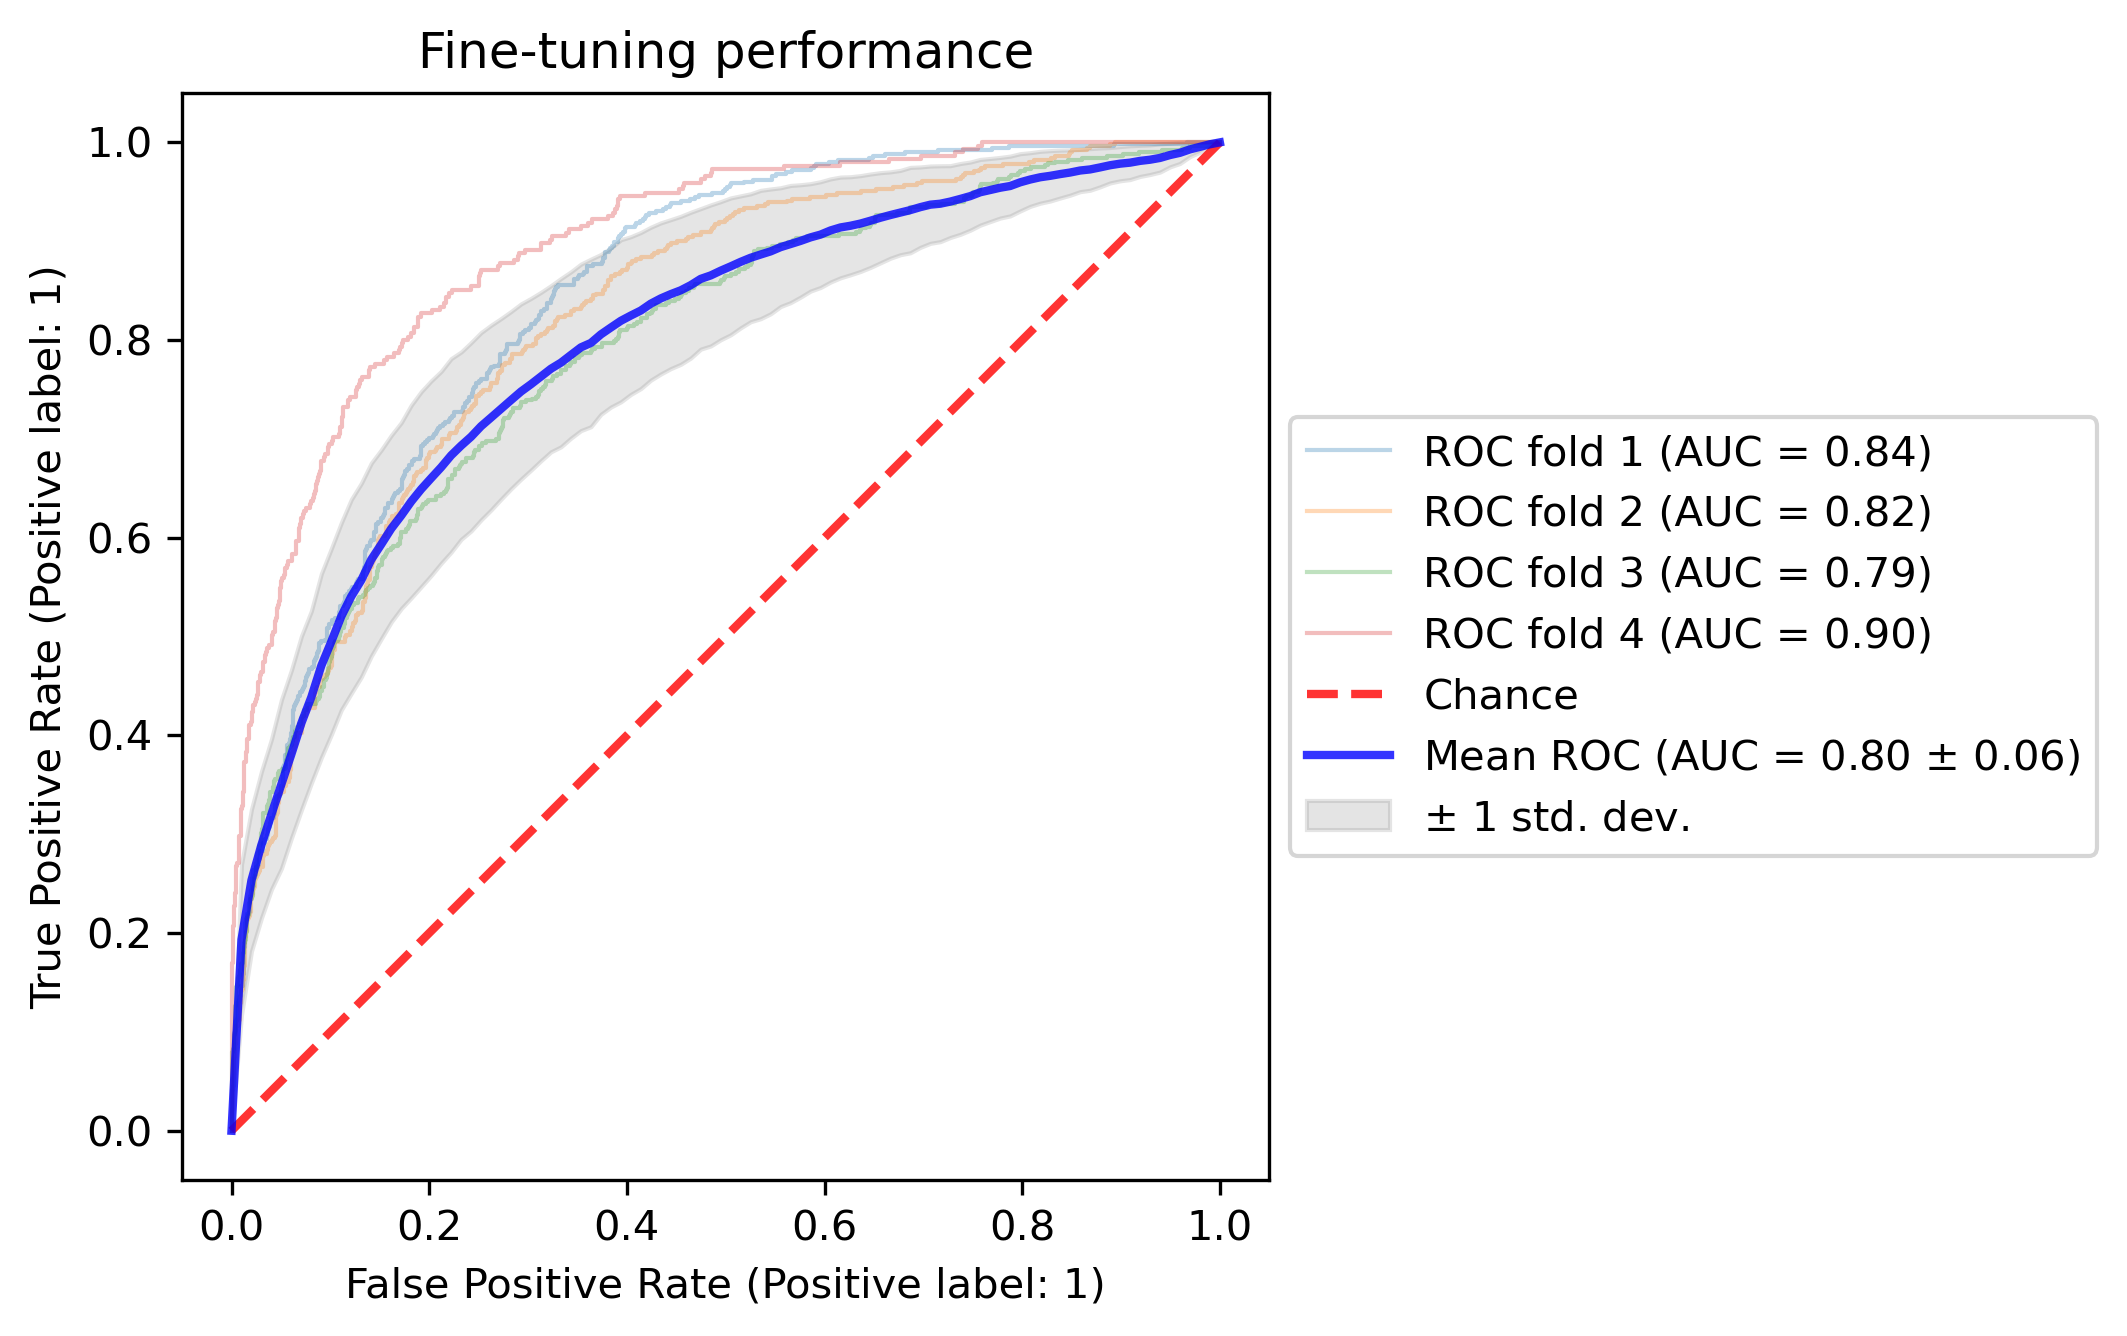

In [149]:
import matplotlib.pyplot as plt
# default: --no-tune --wordvectors none --model cnn --subjpred
parser = argparse.ArgumentParser(description="Run Russian Eye-Movement Pretraining")
parser.add_argument("--model", dest="model")
parser.add_argument("--roc", dest="roc", action="store_true")
parser.add_argument("--tunesets", type=int, default=2)
parser.add_argument("--tune", dest="tune", action="store_true")
parser.add_argument("--no-tune", dest="tune", action="store_false")
parser.add_argument("--pretrain", dest="pretrain", action="store_true")
parser.add_argument("--seed", dest="seed", type=int, default=42)
parser.add_argument("--cuda", dest="cudaid", default=0)
parser.set_defaults(tune=True) 
parser.set_defaults(roc=True)
parser.set_defaults(model = "transformer_tuning")
args = parser.parse_args(args=[]) # modified to work with jupyter notebook

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

start_time = time.time()


if args.model == "transformer_tuning":
    MODEL_CLASS = BinaryTransformerClassifier 
    
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    device = torch.device(f'cuda:{args.cudaid}')
    
# Prepare ROC Curves
if args.roc:
    Roc = ROC(args.model, args.tune)
    
NUM_FOLDS = 4
NUM_TUNE_SETS = args.tunesets
tune = args.tune

BATCH_SIZE = 128
BATCH_SUBJECTS = False

file = 'data/30fixations_no_padding_sentence_word_pos.csv'  # data with dyslexia labels

used_test_params = []
parameter_sample = [
    get_params(hyperparameter_space["transformer_tuning"]) for _ in range(NUM_TUNE_SETS)
]


tprs_folds = {}
loss_fn = nn.BCEWithLogitsLoss()

# load and preprocess data for training
preprocessor = EyetrackingDataPreprocessor(
    csv_file = file, 
   num_folds = NUM_FOLDS
)

test_accuracies = []

for test_fold in range(NUM_FOLDS):
    print("test fold ", test_fold)
    parameter_evaluations = np.zeros(shape=(NUM_FOLDS, NUM_TUNE_SETS))
    if tune:
        # Normal training / fine-tuning
        for dev_fold in range(NUM_FOLDS):
            if args.pretrain:
                pretrained_models = next(pretrained_model_generator)
            if dev_fold == test_fold:
                continue
            print(f'dev fold {dev_fold}')
            train_folds = [
                fold
                for fold in range(NUM_FOLDS)
                if fold != test_fold and fold != dev_fold
            ]

            train_dataset = EyetrackingDataset(
                preprocessor,
                folds=train_folds,
                batch_subjects=BATCH_SUBJECTS,
            )
            mean, sd = getmeansd(train_dataset, batch=BATCH_SUBJECTS)
            train_dataset.standardize(mean, sd)
            dev_dataset = EyetrackingDataset(
                preprocessor,
                folds=[dev_fold],
                batch_subjects=BATCH_SUBJECTS,
            )
            dev_dataset.standardize(mean, sd)
            for tune_set in range(NUM_TUNE_SETS):
                running_model = copy.deepcopy(MODEL_CLASS)
                if tune_set%100 == 0:
                    print(f'tune set {tune_set}')
                model = None
                model = running_model.train_model_bin(
                            train_dataset,
                            min_epochs=15,
                            max_epochs=300,
                            dev_data=dev_dataset,
                            pretrained_model=old_model,
                            device=device,
                            config= parameter_sample[tune_set]
                        )
                tune_accuracy = model.evaluate_bin(
                    data=dev_dataset,
                    device=device,
                    metric="loss",
                    batch_size = parameter_sample[tune_set]["batch_size"]
                )
                parameter_evaluations[dev_fold, tune_set] = tune_accuracy
                print(tune_accuracy)
                del running_model
                gc.collect()
                torch.cuda.empty_cache()

            # Select best parameter set
        mean_dev_loss = np.mean(parameter_evaluations, axis=0)
        best_parameter_set = np.argmin(mean_dev_loss)
        params_test = parameter_sample[best_parameter_set]
        print(f'best performing parameter for dev fold ', dev_fold, ": ", params_test)
        used_test_params.append(params_test)
        best_pretrained_model = None
        
    running_model = copy.deepcopy(MODEL_CLASS)
    dev_fold = (test_fold + 1) % NUM_FOLDS
    train_folds = [
        fold for fold in range(NUM_FOLDS) if fold != test_fold and fold != dev_fold
    ]
    train_dataset = EyetrackingDataset(
        preprocessor,
        folds=train_folds,
        batch_subjects=BATCH_SUBJECTS,
    )
    mean, sd = getmeansd(train_dataset, batch=BATCH_SUBJECTS)
    train_dataset.standardize(mean, sd)
    dev_dataset = EyetrackingDataset(
        preprocessor,
        folds=[dev_fold],
        batch_subjects=BATCH_SUBJECTS
    )
    dev_dataset.standardize(mean, sd)
    test_dataset = EyetrackingDataset(
        preprocessor,
        folds=[test_fold],
        batch_subjects=BATCH_SUBJECTS,
    )
    test_dataset.standardize(mean, sd)
    model = running_model.train_model_bin(
        train_dataset,
        min_epochs=15,
        max_epochs=200,
        dev_data=dev_dataset,
        pretrained_model=old_model,
        device=device,
        config=params_test,
    )
    print(f'test accuraccy fold ', test_fold)
    test_accuracy = model.evaluate_bin(
        test_dataset,
        device=device,
        metric="all",
        print_report=True,
        per_subj=BATCH_SUBJECTS,
        batch_size = params_test["batch_size"]
    )
    # print("test acc fold ", test_fold, " : ", test_accuracy)
    test_accuracies.append(test_accuracy)
    if args.roc:
        y_preds, y_trues, subjs = model.predict_probs(
            test_dataset,
            device=device,
            per_subj=BATCH_SUBJECTS,
            config=params_test
        )
        tprs_folds[str(test_fold)] = (y_trues, y_preds, subjs)
        Roc.get_tprs_aucs(y_trues, y_preds, test_fold)

if tune:
    print("used test params: ", used_test_params)
print(
    "mean:",
    np.mean(test_accuracies, axis=0),
    "std:",
    np.std(test_accuracies, axis=0) / np.sqrt(NUM_FOLDS),
)

if args.roc:
    Roc.plot()
    Roc.save()
    print("auc: ", Roc.mean_auc, "+-", Roc.std_auc)
pred_level = "subjectpred" if BATCH_SUBJECTS else "textpred"
final_scores_mean = np.mean(test_accuracies, axis=0)
final_scores_std = np.std(test_accuracies, axis=0) / np.sqrt(NUM_FOLDS)
final_scores_mean = np.insert(final_scores_mean, 0, Roc.mean_auc, axis=0)
final_scores_std = np.insert(final_scores_std, 0, Roc.std_auc, axis=0)
# out_str = ""
# with open(f"reader_prediction_results/reading_speed_info/{args.model}_scores_{pred_level}.txt", "w") as f:
#     for i in range(len(final_scores_mean)):
#         out_str += f"${round(final_scores_mean[i],2):1.2f}\db{{{round(final_scores_std[i],2):1.2f}}}$"
#         if i < len(final_scores_mean) - 1:
#             out_str += " & "
#         else:
#             out_str += " \\\\ "
#     f.write(out_str)